<div class="alert alert-danger" style="color:black"><b>Running ML-LV Jupyter Notebooks:</b><br>
    <ol>
        <li>Make sure you are running all notebooks using the <code>adv_ai</code> kernel.
        <li><b>It is very important that you do not create any additional files within the weekly folders on CSCT cloud.</b> Any additional files, or editing the notebooks with a different environment may prevent submission/marking of your work.</li>
            <ul>
                <li>NBGrader will automatically fetch and create the correct folders files for you.</li>
                <li>All files that are not the Jupyter notebooks should be stored in the 'ML-LV/data' directory.</li>
            </ul>
        <li>Please <b>do not pip install</b> any python packages (or anything else). You should not need to install anything to complete these notebooks other than the packages provided in the Jupyter CSCT Cloud environment.</li>
    </ol>
    <b>If you would like to run this notebook locally you should:</b><br>
    <ol>
        <li>Create an environment using the requirements.txt file provided. <b>Any additional packages you install will not be accessible when uploaded to the server and may prevent marking.</b></li>
        <li>Download a copy  of the notebook to your own machine. You can then edit the cells as you wish and then go back and copy the code into/edit the ones on the CSCT cloud in-place.</li>
        <li><b>It is very important that you do not re-upload any notebooks that you have edited locally.</b> This is because NBGrader uses cell metadata to track marked tasks. <b>If you change this format it may prevent marking.</b></li>
    </ol>
</div>

# Practical 9: Convolutional Neural Networks

In the previous practical we applied several supervised and unsupervised algorithms to image classification for the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset. These algorithms perform remarkably well on the relatively simple digit images. However, you may have noticed they did not perform very well on your own handwritten digits. This is, at least in part, because these algorithms are highly sensitive to spatial variations within the image. Thus, these algorithms are quite brittle and will not perform well on more complex images.

Convolutional Neural Networks (CNN) are the predominant network architecture for image classification and many other related tasks, such as object detection and image segmentation. They are inspired by the work of [Hubel, D. H. and Wiesel, T. N. (1959)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1363130/pdf/jphysiol01298-0128.pdf) on the receptive fields within a Cat's visual cortex. They noticed that certain (simple) cells only reacted to edges of a specific orientation, while more complex cells combined the outputs of simple cells and were able to respond to edges anywhere within the visual field. CNNs use these ideas in the form of *local receptive fields* and *shared weights* (convolution layers) and *spatial or temporal sub-sampling* (pooling layers). This makes them much more robust to variations within images, such as shifting patterns, occluded shapes and so on.

In the first part of this practical we will examine what a convolution is and how they can be used as simple edge, or feature detectors.

In the second part of this practical we will build and apply a simple CNN to classify the MNIST dataset, and our own handwritten digits.

In the third part of this practical we will build a more complex CNN and use it to classify the flowers dataset.

The objectives of this practical are:

1. Understand the process of convolutions and the purpose of using different Kernels within CNNs

2. Consider the role of convolutional layers and pooling layers within CNNs

3. Apply a complete MV workflow for image classification with CNNs, including the use large pre-trained image classifiers for transfer learning

# 1 What is a Convolution

For decades before the invention of 'neocognitrons' (nowadays better known as Convolutional Neural Networks),
image processing experts relied on the concepts of transforming images by moving a small 'kernel' (also called a filter) across the image. The basic idea is to transform the image by using simple local processing which you apply at each different point in the image. Effectively a neighbourhood transform.

To illustrate this process we will start by using a hand-drawn number (so we can process it quickly without code optimisations) and a simple vertical edge detector called the Prewitt Filter (technically the Prewitt uses vertical and horizontal versions then combines them).

## 1.0 Import libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress Tensorflow messages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from IPython.display import HTML
%matplotlib inline

# Get the status of NBgrader (for skipping cell execution while validating/grading)
grading = True if os.getenv('NBGRADER_EXECUTION') else False

# Set seaborn style for matplotlib plots
plt.style.use('seaborn-v0_8-white')

# Get the project directory (should be in ML-LV)
path = ''
while os.path.basename(os.path.abspath(path)) != 'ML-LV':
    path = os.path.abspath(os.path.join(path, '..'))

# Set the directory to the datasets folder (should be in shared/datasets/mnist)
datasets_dir = os.path.join(path, '..', 'shared', 'datasets', 'mnist')

## 1.1 Load digit data

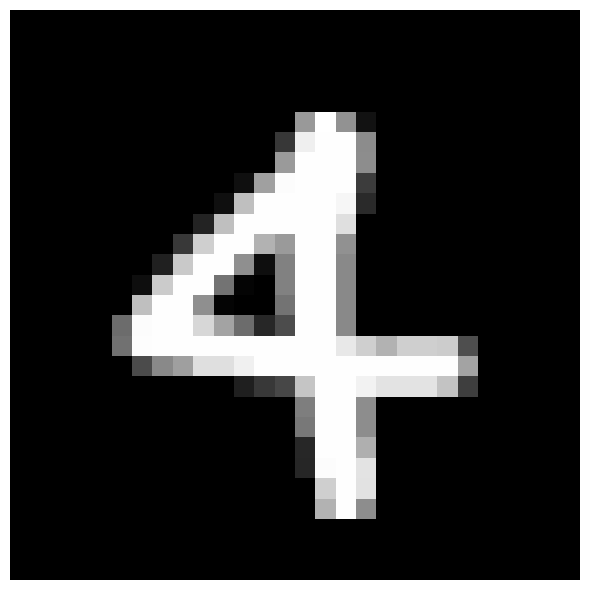

In [2]:
# Load the MNIST dataset
(X_train, y_train), (X_val, y_val) = tf.keras.datasets.mnist.load_data(path=os.path.join(datasets_dir, 'mnist.npz'))

# Randomly select an image of a specific digit
digit = 4
digit_indexes = np.where(y_train == digit)[0]
rand_index = np.random.choice(digit_indexes, 1)[0]
digit_img = X_train[rand_index]

# Display digit
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(digit_img, cmap='gray')
ax.axis('off')
fig.tight_layout()
plt.show()

## 1.2 Define a kernel

Create a simple vertical edge detector that looks at the average of the difference between the pixels on the left and those to  the right of where the kernel is on the image.

First we will define a 3x3 kernel:

$ k = \begin{bmatrix}
1 & 0 & -1\\
1 & 0 & -1\\
1 & 0 & -1\\
\end{bmatrix} $

The kernel is then passed over the image and **convolved** (combined) with the pixels within the *sub-image* (the current 3x3 pixel values 'underneath' the kernel) to calculate a new value for the central pixel. At each step the pixels within the sub-image are multiplied by the *weight* in the corresponding position within the kernel. Then add up the result and set to the central pixel value in the new image.

More formally:

$ pixel[i] = \sum_{j=1}^n k_j s[i]_j $

Where $i$ is the current central pixel within the original image, $s[i]$ is the central pixel of the sub-image and $n = height \times width $ of the kernel.

![Illustration of convoltion from wikicommons](https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif)

**Padding**: Notice that since we put the result of our calculations into the pixel in the middle, we lose a border around the edge of the original image. With a 3x3 kernel it is not possible to calculate a new pixel value for the 1 pixel border around the image. For a 5x5 kernel the border would be 2 pixels. In CNNs this is usually accounted for by **padding** the image with 0's, which will not impact the output of the kernel and allow us to preserve all of the original pixel values. However, in this case the MNIST images already have a 4x4 border of 0's around the digit, so we wont lose any information.

**Stride**: Here we are passing the kernel over the image 1 pixel at a time. However, sometimes, either for computational efficiency or because we wish to downsample, we move our kernel more than 1 pixel at a time, skipping the intermediate locations. This is particularly useful if the kernel is large, since it captures a larger area of the underlying image. The amount the kernel is moved at each step is called the **stride**.

In [3]:
# Define the kernel
kernel = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])

kernel_height = kernel.shape[0]
kernel_width = kernel.shape[1]

# Calculate the border size to be lost
border_x = kernel_height // 2
border_y = kernel_width // 2

# Calculate the output image size
new_height = digit_img.shape[0] - 2 * border_x
new_width = digit_img.shape[1] - 2 * border_y

# Create the sub-image and output image
sub_image = np.zeros((kernel_width, kernel_height), dtype='uint8')
new_image = np.zeros((new_height, new_width), dtype='uint8')

print(f"Original image shape: {digit_img.shape}")
print(f"Kernel shape: {kernel.shape}")
print(f"Sub-image shape: {sub_image.shape}")
print(f"Output image shape: {new_image.shape}")

Original image shape: (28, 28)
Kernel shape: (3, 3)
Sub-image shape: (3, 3)
Output image shape: (26, 26)


## 1.3 Perform convolution

The following cell creates an animation of the convolution process. The convolution operation is performed within the `animate_convolution()` function.

- The first plot is the original digit image with the current position of the kernel overlayed in yellow.

- The middle plot shows the current sub-image, with the kernel weights overlayed. The result of the convolution operation is displayed at the top.

- The final plot shows the resulting output image.

<div class="alert alert-danger" style="color:black"><b>Warning:</b> This cell can take a while to run on the UWE machines/CSCT cloud!<br></div>

In [1]:
# if not grading:
#     # Plot the convolution process
#     fig, ax = plt.subplots(1, 3, figsize=(8, 6))

#     # Show original image
#     ax[0].imshow(digit_img, cmap='gray', vmin=0, vmax=255)

#     # Add yellow outline of kernel position
#     a0 = ax[0].add_patch(Rectangle([0, 0], kernel_width, kernel_height, fill=False, edgecolor='yellow', lw=1))

#     # Plot the sub-image lying under the current kernel position
#     a1 = ax[1].imshow(sub_image, cmap='gray', vmin=0, vmax=255)
#     # Also show the corresponding kernel values in red
#     for sub_x in range(kernel_width):
#         for sub_y in range(kernel_height):
#             text = ax[1].text(sub_y, sub_x, kernel[sub_x, sub_y], ha="left", va="bottom", color="r")

#     # Show the output image
#     a2 = ax[2].imshow(new_image, cmap='gray', vmin=0, vmax=255)
#     ax[2].set_title('Output Image')

#     # Define the animation function
#     def animate_convolution(i):

#         # Get the current kernel position
#         x = i % new_width
#         y = i // new_width

#         # Update the yellow outline of the kernel position
#         a0.set(y=y - border_y, x=x - border_x)
#         ax[0].set_title(f'Kernel Position: {a0.get_xy()}')

#         # Update the sub-image
#         sub_image = np.zeros((kernel_height, kernel_width), dtype=int)
#         for sub_y in range(kernel_height):
#             pixel_y = (y - border_y) + sub_y
#             for sub_x in range(kernel_width):
#                 pixel_x = (x - border_x) + sub_x 
#                 sub_image[sub_y][sub_x] = digit_img[pixel_y][pixel_x]

#         # Update kernel display
#         a1.set_data(sub_image)

#         # Perform convolution
#         result = kernel * sub_image
#         new_pixel_val = np.sum(result)
#         new_pixel_val = np.clip(new_pixel_val, 0, 255)
#         ax[1].set_title(f'Computed value {new_pixel_val}')

#         # Update the output image
#         new_image[y][x] = int(new_pixel_val)
#         a2.set_data(new_image)

#     # Create the animation
#     anim = FuncAnimation(fig, animate_convolution, frames=new_height*new_width-1, interval=50, repeat=True, repeat_delay=1000)
#     html = HTML(anim.to_jshtml())
#     display(html)
#     plt.close()

<div class="alert alert-success" style="color:black"><h3>Before you submit this notebook to NBGrader for marking:</h3> 

1. Make sure have completed all exercises marked by <span style="color:blue">**blue cells**</span>.
2. For automatically marked exercises ensure you have completed any cells with `# YOUR CODE HERE`. Then click 'Validate' button above, or ensure all cells run without producing an error.
3. For manually marked exercises ensure you have completed any cells with `"YOUR ANSWER HERE"`.
4. Ensure all cells are run with their output visible.
5. Fill in your student ID (**only**) below.
6. You should now **save and download** your work.

</div>

**Student ID:** 15006280